In [1]:
import os
import pickle

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

import geopandas
import cartopy.crs as ccrs
from shapely.geometry import Point, shape

from joblib import Parallel, delayed

## Prep
### subset the data request

In [2]:
# subset the data
minx_index, maxx_index, miny_index, maxy_index = 11800, 13029, 2894, 2325
minx_index, maxx_index, miny_index, maxy_index = str(minx_index), str(maxx_index), str(miny_index), str(maxy_index)

firstday = 4348
lastday = 4350

firstday = str(firstday)
lastday = str(lastday)

### request data

In [3]:
url = "https://www.oceancolour.org/thredds/dodsC/CCI_ALL-v6.0-1km-DAILY?lat["+maxy_index+":1:"+miny_index+"],lon["+minx_index+":1:"+maxx_index+"],chlor_a["+firstday+":1:"+lastday+"]["+maxy_index+":1:"+miny_index+"]["+minx_index+":1:"+maxx_index+"],time["+firstday+":1:"+lastday+"]"
ds = nc.Dataset(url)

### load in lats, lons, and polygons

nice, it rhymes.

In [6]:
lons = ds.variables['lon'][:]
lats = ds.variables['lat'][:]

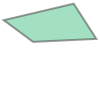

In [7]:
# Load polygons from shape file 
polygon_file = os.path.join('..', 'polygons', 'Arrigo et al 2017 Sample Areas.shp')

polygons  = geopandas.GeoDataFrame.from_file(polygon_file)
polygons.geometry[0]

## Create Masks

In [8]:
def create_mask(x):
    # Create a 2D numpy mask
    mask = np.ones((len(lats), len(lons)))

    # Check if each (lat, lon) is in the polygon and mask it if not
    for i in range(len(lats)):
        for j in range(len(lons)):
            point = Point(lons[j], lats[i])
            if not point.within(polygons.geometry[x]):
                mask[i, j] = np.nan

    # Create a masked array
    masked_array = np.ma.masked_invalid(mask)

    # Save the masked array to a pickle file
    if not os.path.exists(os.path.join('..', 'masks')):
        os.makedirs(os.path.join('..', 'masks'))
    with open(os.path.join('..', 'masks', 'masked_array'+str(x)+'.pkl'), 'wb') as f:
        pickle.dump(masked_array, f) 

# Run the create_mask function in parallel for the 6 polygons
Parallel(n_jobs=-1)(delayed(create_mask)(x) for x in range(6))

[None, None, None, None, None, None]

## Plot and admire

In [9]:
# Open the masked arrays
masked_arrays = []
for x in range(6):
    with open(os.path.join('..', 'masks', 'masked_array'+str(x)+'.pkl'), 'rb') as f:
    # with open('masked_array' + str(x) + '.pkl', 'rb') as f:
        masked_arrays.append(pickle.load(f))
    

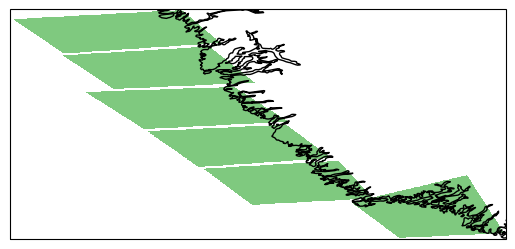

In [10]:
# Create a figure and axis with a specific projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Iterate over the masked arrays and plot each array
for i, masked_array in enumerate(masked_arrays):
    # Plot the masked array
    ax.imshow(masked_array, origin='upper', extent=[lons.min(), lons.max(), lats.min(), lats.max()], cmap='Accent')

# Overlay the map
ax.coastlines()

# Show the plot
plt.show()
